In [2]:
from mudpy import forward
from mudpy import view
import numpy as np
import matplotlib.pyplot as plt

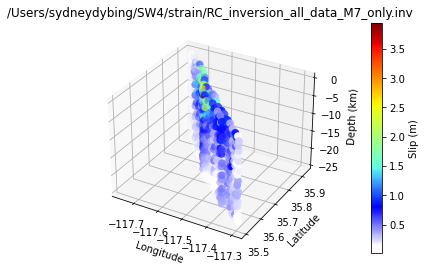

In [16]:
# Make SRF from the updated .inv file for Ridgecrest from Dara

inv = '/Users/sydneydybing/SW4/strain/RC_inversion_all_data_M7_only.inv'

view.slip3D(rupt = inv)

In [21]:
# def mudpy2srf_multiplane(rupt, log_file, stf_dt = 0.1, stf_type = 'triangle', inv_or_rupt = 'rupt', Ndip = None,
#               hypocenter = None, time_pad = 5.0, minSTFpoints = 16, integrate = False, Mw = None):
#     '''
#     Convert a mudpy .rupt or .inv file to SRF version 2 format
#     Edited April 2024 by Sydney to allow for multiple planes
    
#     See for SRF format description here:
#         https://scec.usc.edu/scecpedia/Standard_Rupture_Format
        
#     if Ndip ! =  None it means try to apportion Nstrike and Ndip to avoid huge Nstrike number
#     '''
    
from numpy import genfromtxt,where,sin,deg2rad,array,argmin,sqrt,sign,arctan2,rad2deg,arange,ones,zeros,r_
from pyproj import Geod
from os import path
from scipy.integrate import cumtrapz

rupt = inv
inv_or_rupt = 'inv'

#Define paths to output files
folder = path.dirname(rupt)
basename = path.basename(rupt)

if inv_or_rupt == 'rupt':
    basename = basename.replace('rupt','srf')
    srf_file = folder+'/'+basename
    basename = basename.replace('srf','src')
    src_file = folder+'/'+basename
else:
    basename = basename.replace('inv','srf')
    srf_file = folder+'/'+basename
    basename = basename.replace('srf','src')
    src_file = folder+'/'+basename       

#Read mudpy file
f = genfromtxt(rupt)

print(f)

# #Calculate stuff for the header

# #Get coordinates of shallowest row
# min_row = where(f[:,3] =  = f[:,3].min())[0]
# fmin = f[min_row,:]

# #Top center longitude
# elon = fmin[:,1].mean()

# #Top center latitude
# elat = fmin[:,2].mean()

# if Ndip =  = None:
#     #Number of faults along strike
#     Nstrike = len(fmin)
#     #Number of faults along dip
#     Ndip = len(f)/Nstrike
# else:
#     #Number of faults along strike
#     Nstrike = len(f)/Ndip

# #Subfault dimensions (in km)
# dx_strike = f[0,10]/1000.0
# dx_dip = f[0,11]/1000.0

# #Segment length and width
# length = Nstrike*dx_strike
# width = Ndip*dx_dip

# #Segment strike and dip
# strike = f[0,4]
# dip = f[0,5]

# #Depth to top of fault
# depth_top = fmin[0,3]-sin(deg2rad(dip))*(dx_dip/2)

# if inv_or_rupt == 'rupt':
#     #Location of hypocenter from log file and magnitude
#     flog = open(log_file,'r')
#     while True:
#         line = flog.readline()
#         if 'Hypocenter (lon,lat,z[km])' in line:                
#             s = line.split(':')[-1]
#             s = s.replace('(','')
#             s = s.replace(')','')
#             hypocenter = array(s.split(',')).astype('float')
#         if 'Actual magnitude' in line:
#             Mw = float(line.split()[-1])
#         elif line == '':
#             break 
#     flog.close()
# else:
#     pass

# #Down dip location with regards to top of fault
# dip_hypo_position = (hypocenter[2]-depth_top)/sin(deg2rad(dip))

# #Get hypocenter row of subfaults and find coordinates of middle
# i = argmin(abs(f[:,3]-hypocenter[2]))
# test_depth = f[i,3]
# hypo_row = where(f[:,3] == test_depth)[0]
# hypo_center_lon = f[hypo_row,1].mean()
# hypo_center_lat = f[hypo_row,2].mean()
# #Distance from edge
# g = Geod(ellps = 'WGS84')
# az,baz,dist_from_center = g.inv(hypocenter[0],hypocenter[1],hypo_center_lon,hypo_center_lat)

# #Now decide if distance is positive or negative
# if strike>180:
#     strike_rectified = strike-360
# else:
#     strike_rectified = strike

# if sign(az) == sign(strike_rectified):
#     strike_hypo_position = -dist_from_center/1000
# else:
#     strike_hypo_position = dist_from_center/1000

# #open SRF file and write header data
# fout = open(srf_file,'w')
# fout.write('2.0\n') #SRF version
# fout.write('PLANE 1\n')
# fout.write('  %.6f\t%.6f\t%d\t%d\t%.4f\t%.4f\n' % (elon,elat,Nstrike,Ndip,length,width))
# fout.write('  %.4f\t%.4f\t%.4f\t%.4f\t%.4f\n' % (strike,dip,depth_top,strike_hypo_position,dip_hypo_position))
# fout.write('POINTS %d\n' % (Nstrike*Ndip))

# #While we're here let's write the SRC file too
# fsrc = open(src_file,'w')
# fsrc.write('MAGNITUDE  =  %.4f\n' % Mw)
# fsrc.write('FAULT_LENGTH  =  %.4f\n' % length)
# fsrc.write('DLEN  =  %.4f\n' % dx_strike)
# fsrc.write('FAULT_WIDTH  =  %.4f\n' % width)
# fsrc.write('DWID  =  %.4f\n' % dx_dip)
# fsrc.write('DEPTH_TO_TOP  =  %.4f\n' % depth_top)
# fsrc.write('STRIKE  =  %.4f\n' % strike)
# fsrc.write('RAKE  =  9999\n')
# fsrc.write('DIP  =  %.4f\n' % dip)
# fsrc.write('LAT_TOP_CENTER  =  %.4f\n' % elat)
# fsrc.write('LON_TOP_CENTER  =  %.4f\n' % elon)
# fsrc.write('HYPO_ALONG_STK  =  %.4f\n' % strike_hypo_position)
# fsrc.write('HYPO_DOWN_DIP  =  %.4f\n' % dip_hypo_position)
# fsrc.write('DT  =  0.01\n')
# fsrc.write('SEED  =  1')
# fsrc.close()

# #And that was jsut the headers, now let's move on to getting the subfault source time functions
# # Note mudpy works in mks SRF is cgs so must convert accordingly
# minNTstf = 99999
# for kfault in range(len(f)):
#     print(kfault)
#     zero_slip = False
#     #Get values for "Headers" for this subfault
#     lon = f[kfault,1]
#     lat = f[kfault,2]
#     depth = f[kfault,3]
#     strike = f[kfault,4]
#     dip = f[kfault,5]
#     area = f[kfault,10]*f[kfault,11]*100**2
#     tinit = f[kfault,12]
#     vs = 2.80000e+05    #Default value for not known
#     density = 2.70000e+00 #default value for not known
#     rake = rad2deg(arctan2(f[kfault,9],f[kfault,8]))
#     slip = sqrt(f[kfault,8]**2+f[kfault,9]**2)*100

#     #Now get source time function
#     rise_time = f[kfault,7]
#     total_time = rise_time*1.5
#     #If subfault has zero rise time make it have tiny slip rate
#     if slip =  = 0:
#         zero_slip = True
#         stf  =  zeros(int(total_time/stf_dt))
#         print('Zero slip at '+str(kfault))
#     elif rise_time =  = 0:
#         slip = 0
#         zero_slip = True
#         stf  =  zeros(int(total_time/stf_dt))
#         print('Zero rise time at '+str(kfault))
#     else:
#         tstf,stf = build_source_time_function(rise_time,stf_dt,total_time,stf_type = stf_type,zeta = 0.2,scale = True)
#         #tstf,stf = build_source_time_function(rise_time,stf_dt,total_time,stf_type = 'triangle',scale = True)
#         #Scale stf so integral matches total slip
#         stf_adjust_factor = slip/stf_dt
#         stf = stf*stf_adjust_factor #now tf is in cm/sec       

#     #Now zero pad before and after end because SW4 struggles if subfault STFs are not zero padded
#     if time_pad ! =  None:
#         zeros_pad = zeros(int(time_pad/stf_dt))
#         stf = r_[zeros_pad,stf,zeros_pad]
#         #Change start time of STF, it should now begin time_pad seconds earlier
#         tinit = tinit-time_pad

#     #How mant STF points?
#     NTstf = len(stf)
#     if NTstf<minSTFpoints: #Too short, zero pad
#         print('Padding short STF...')
#         zeros_pad = zeros(int(minSTFpoints/2))
#         stf = r_[zeros_pad,stf,zeros_pad]
#         #Change start time of STF, it should now begin time_pad seconds earlier
#         time_shift = int(minSTFpoints/2)*stf_dt
#         tinit = tinit-time_shift    


#     #Check that everything is ok
#     NTstf = len(stf)
#     if NTstf<minNTstf:
#         minNTstf = NTstf

#     if zero_slip =  = True:
#         NTstf = 0

#     #Write the subfault headers
#     fout.write('  %.6f  %.6f  %.5e  %.2f  %.2f  %.5e  %.4f  %.4e  %.4e  %.4e\n' % (lon,lat,depth,strike,dip,area,tinit,stf_dt,vs,density))
#     fout.write('  %.2f  %.4f  %d  0  0  0  0\n' % (rake,slip,NTstf))


#     if zero_slip =  = False:
#         #Integrate to slip instead of slip rate?
#         if integrate =  = True:
#             t = arange(0,len(stf)*stf_dt,stf_dt)
#             if len(t)>len(stf):
#                 t = t[0:-1]
#             print(t.shape)
#             print(stf.shape)
#             stf_integrated = cumtrapz(stf,t,initial = 0)
#             stf = stf_integrated

#         #Write stf 6 values per line
#         for kstf in range(NTstf):
#             if kstf =  = 0:
#                 white_space = '  '
#             elif (kstf+1) % 6  =  =  0:
#                 white_space = '\n'
#             elif (kstf+1) =  = NTstf:
#                 white_space = '\n'
#             else:
#                 white_space = '  '

#             if kstf =  = 0:
#                 pre_white_space = '  '
#             elif (kstf) % 6  =  =  0:
#                 pre_white_space = '  '
#             #elif (kstf+1) =  = NTstf:
#             #    pre_white_space = '  '
#             else:
#                 pre_white_space = ''
#             fout.write('%s%.6e%s' % (pre_white_space,stf[kstf],white_space))


# # And done
# print('minNTstf is: '+str(minNTstf))
# fout.close()


[[ 3.850000e+02 -1.172977e+02  3.550590e+01 ...  1.936500e+03
   2.063680e+01  3.970100e+10]
 [ 3.860000e+02 -1.177555e+02  3.592970e+01 ...  1.944200e+03
   1.135390e+01  3.661200e+10]
 [ 3.870000e+02 -1.177077e+02  3.589230e+01 ...  2.073600e+03
   8.389200e+00  3.661200e+10]
 ...
 [ 1.006000e+03 -1.174202e+02  3.559310e+01 ...  1.915700e+03
   1.408560e+01  2.994800e+10]
 [ 1.007000e+03 -1.174151e+02  3.558650e+01 ...  2.128400e+03
   1.440700e+01  3.332700e+10]
 [ 1.008000e+03 -1.174045e+02  3.557460e+01 ...  2.366400e+03
   1.519600e+01  3.661200e+10]]


In [17]:
mudpy2srf(rupt = inv, log_file = None, inv_or_rupt = 'inv')

TypeError: 'NoneType' object is not subscriptable

In [12]:
def build_source_time_function(rise_time,dt,total_time,stf_type='triangle',zeta=0.2,dreger_falloff_rate=4,
                               scale=True,scale_value=1.0,time_offset=0,time_offset_gauss=0,quiet=False,
                               ji_fraction=0.5):
    '''
    Compute source time function for a given rise time
    '''
    from numpy import zeros,arange,where,pi,cos,sin,isnan,exp,roll
    from scipy.integrate import trapz
    
    rise_time=float(rise_time)
    #Initialize outputs
    t=arange(0,total_time+dt,dt)
    Mdot=zeros(t.shape)
    if stf_type=='triangle':
        #Triangle gradient
        m=1/(rise_time**2)
        #Upwards intercept
        b1=0
        #Downwards intercept
        b2=m*(rise_time)
        #Assign moment rate
        i=where(t<=rise_time/2)[0]
        Mdot[i]=m*t[i]+b1
        i=where(t>rise_time/2)[0]
        Mdot[i]=-m*t[i]+b2 
        i=where(t>rise_time)[0]
        Mdot[i]=0
    elif stf_type=='cosine':   #From Liu et al. (2006) BSSA, eq 7a,7b
        tau1=0.13*rise_time
        tau2=rise_time-tau1
        Cn=pi/(1.4*pi*tau1+1.2*tau1+0.3*pi*tau2)
        #Build in pieces
        i1=where(t<tau1)[0]
        i2=where((t>=tau1) & (t<2*tau1))[0]
        i3=where((t>=2*tau1) & (t<rise_time))[0]
        Mdot[i1]=Cn*(0.7-0.7*cos(t[i1]*pi/tau1)+0.6*sin(0.5*pi*t[i1]/tau1))
        Mdot[i2]=Cn*(1.0-0.7*cos(t[i2]*pi/tau1)+0.3*cos(pi*(t[i2]-tau1)/tau2))
        Mdot[i3]=Cn*(0.3+0.3*cos(pi*(t[i3]-tau1)/tau2))
    elif stf_type=='dreger':
        tau=rise_time/dreger_falloff_rate
        Mdot=(t**zeta)*exp(-t/tau)
    elif stf_type == 'gauss_prem_i_2s':  #The decay parameter for this is fixed by instaseis/syngine
    
        decay=3.5 #Hard coded in syngine, good number for rise time to actually correspond to the function width
        center_time = 3.5858 #Hard coded in syngine
        min_rise_time = 2.1 #Rise times shorter than this are not allowed
        if rise_time < min_rise_time:
            if quiet==False:
               print('... ... ...  WARNING: rise time requested is below minimum allowed of %.1fs, defaulting to minimum' % min_rise_time)
            rise_time = min_rise_time
    
        if time_offset_gauss == 0 : #regualr gaussian with no offset (for GNSS, strong motion, etc)
            time_offset_gauss = rise_time/2
            Mdot = decay/(rise_time*pi**0.5)*exp(-((decay * (t - time_offset_gauss))/rise_time)**2)
            Mdot -= Mdot[0]
            i = where(Mdot < 0)[0]
            Mdot[i] = 0
    
        else: #regular gaussian with offset (for teleseismic, etc)
            Mdot = decay/(rise_time*pi**0.5)*exp(-((decay * (t - time_offset_gauss))/rise_time)**2)
            #Here comes the tricky bit. Need to roll the slip rate function FORWARD
            # By an ammount equal to half the new rise time minus half original rise time (2.1/2)
            t_roll = rise_time/2 - min_rise_time/2
            t_roll_samples = int(t_roll/dt)
            Mdot = roll(Mdot,t_roll_samples)
    elif stf_type == 'ji':
        
        tup = rise_time*ji_fraction
        tdown = rise_time*(1-ji_fraction)
    
        #Up going cosine
        s1 = (1./(tup+tdown))*(1-cos((pi*t)/tup))
        i = where(t>tup)[0]
        s1[i] = 0
        
        #Down going cosine
        s2 = (1./(tup+tdown))*(1+cos((pi*(t-tup))/tdown))
        i = where(t<=tup)[0]
        s2[i] = 0 
        i = where(t>tup+tdown)[0]
        s2[i] = 0
        
        #add the two 
        Mdot = s1+s2    
    
    else:
        print('ERROR: unrecognized STF type '+stf_type)
        return
    #Area of STF must be equal to dt
    if scale==True:

        area=trapz(Mdot,t)
        Mdot=Mdot*(scale_value/area)
    #Check for errors
    if isnan(Mdot[0])==True:
        print('ERROR: woops, STF has nan values!')
        return
        
    #offset origin time
    t=t+time_offset
    return t,Mdot

In [13]:
def usgs2rupt(usgs_model,out_file,Dx,Dy,N_header_lines= 9,rise_time_multiplier=1):
    '''
    Convert USGS finite fault to .fault
    '''
    from numpy import genfromtxt,ones,arange,savetxt,c_,deg2rad,cos,sin,zeros
    
    lon=genfromtxt(usgs_model,usecols=1,skip_header = N_header_lines)
    lat=genfromtxt(usgs_model,usecols=0,skip_header = N_header_lines)
    z=genfromtxt(usgs_model,usecols=2,skip_header = N_header_lines)
    st=genfromtxt(usgs_model,usecols=5,skip_header = N_header_lines)
    dip=genfromtxt(usgs_model,usecols=6,skip_header = N_header_lines)
    rake=genfromtxt(usgs_model,usecols=4,skip_header = N_header_lines)
    slip=genfromtxt(usgs_model,usecols=3,skip_header = N_header_lines)
    time=genfromtxt(usgs_model,usecols=7,skip_header = N_header_lines)
    
    tup = genfromtxt(usgs_model,usecols=8,skip_header = N_header_lines)
    tdown = genfromtxt(usgs_model,usecols=9,skip_header = N_header_lines)
    rise = tup + tdown
    fraction = tup / rise
    
    rise = rise * rise_time_multiplier
    #Parse rake out into SS and DS
    ss=(slip/100)*cos(deg2rad(rake))
    ds=(slip/100)*sin(deg2rad(rake))
    
    no=arange(1,len(lon)+1)
    H=Dx*ones(len(lon))
    W=Dy*ones(len(lon))
    mu=zeros(len(lon))

    out=c_[no,lon,lat,z,st,dip,fraction,rise,ss,ds,H,W,time,mu]
    savetxt(out_file,out,fmt='%d\t%10.4f\t%10.4f\t%8.4f\t%6.1f\t%6.1f\t%6.4f\t%6.2f\t%8.4f\t%8.4f\t%.1f\t%.1f\t%.2f\t%d')

In [7]:
def mudpy2srf(rupt,log_file,stf_dt=0.1,stf_type='triangle',inv_or_rupt='rupt',Ndip=None,
              hypocenter=None,time_pad=5.0,minSTFpoints=16,integrate=False,Mw=None):
    '''
    Convert a mudpy .rupt or .inv file to SRF version 2 format
    
    See for SRF format description here:
        https://scec.usc.edu/scecpedia/Standard_Rupture_Format
        
    if Ndip != None it means try to apportion Nstrike and Ndip to avoid huge Nstrike number
    '''
    
    from numpy import genfromtxt,where,sin,deg2rad,array,argmin,sqrt,sign,arctan2,rad2deg,arange,ones,zeros,r_
    from pyproj import Geod
    from os import path
    from scipy.integrate import cumtrapz
    
    #Define paths to output files
    folder=path.dirname(rupt)
    basename=path.basename(rupt)
    
    if inv_or_rupt == 'rupt':
        basename=basename.replace('rupt','srf')
        srf_file=folder+'/'+basename
        basename=basename.replace('srf','src')
        src_file=folder+'/'+basename
    else:
        basename=basename.replace('inv','srf')
        srf_file=folder+'/'+basename
        basename=basename.replace('srf','src')
        src_file=folder+'/'+basename       
    
    #Read mudpy file
    f=genfromtxt(rupt)
    
    
    #Calculate stuff for the header
    
    #Get coordiantes of shallowest row
    min_row=where(f[:,3]==f[:,3].min())[0]
    fmin=f[min_row,:]
    
    #Top center longitude
    elon=fmin[:,1].mean()
    
    #Top center latitude
    elat=fmin[:,2].mean()
    
    if Ndip==None:
        #Number of faults along strike
        Nstrike=len(fmin)
        #Number of faults along dip
        Ndip=len(f)/Nstrike
    else:
        #Number of faults along strike
        Nstrike=len(f)/Ndip
        
    #Subfault dimensions (in km)
    dx_strike=f[0,10]/1000.0
    dx_dip=f[0,11]/1000.0
    
    #Segment length and width
    length=Nstrike*dx_strike
    width=Ndip*dx_dip
    
    #Segment strike and dip
    strike=f[0,4]
    dip=f[0,5]
    
    #Depth to top of fault
    depth_top=fmin[0,3]-sin(deg2rad(dip))*(dx_dip/2)
    
    if inv_or_rupt == 'rupt':
        #Location of hypocenter from log file and magnitude
        flog=open(log_file,'r')
        while True:
            line=flog.readline()
            if 'Hypocenter (lon,lat,z[km])' in line:                
                s=line.split(':')[-1]
                s=s.replace('(','')
                s=s.replace(')','')
                hypocenter=array(s.split(',')).astype('float')
            if 'Actual magnitude' in line:
                Mw=float(line.split()[-1])
            elif line=='':
                break 
        flog.close()
    else:
        pass
    
    #Down dip location with regards to top of fault
    dip_hypo_position=(hypocenter[2]-depth_top)/sin(deg2rad(dip))
    
    #Get hypocenter row of subfaults and find coordinates of middle
    i=argmin(abs(f[:,3]-hypocenter[2]))
    test_depth=f[i,3]
    hypo_row=where(f[:,3]==test_depth)[0]
    hypo_center_lon=f[hypo_row,1].mean()
    hypo_center_lat=f[hypo_row,2].mean()
    #Distance from edge
    g=Geod(ellps='WGS84')
    az,baz,dist_from_center=g.inv(hypocenter[0],hypocenter[1],hypo_center_lon,hypo_center_lat)
    
    #Now decide if distance is positive or negative
    if strike>180:
        strike_rectified=strike-360
    else:
        strike_rectified=strike
    
    if sign(az)==sign(strike_rectified):
        strike_hypo_position=-dist_from_center/1000
    else:
        strike_hypo_position=dist_from_center/1000
        
    #open SRF file and write header data
    fout=open(srf_file,'w')
    fout.write('2.0\n') #SRF version
    fout.write('PLANE 1\n')
    fout.write('  %.6f\t%.6f\t%d\t%d\t%.4f\t%.4f\n' % (elon,elat,Nstrike,Ndip,length,width))
    fout.write('  %.4f\t%.4f\t%.4f\t%.4f\t%.4f\n' % (strike,dip,depth_top,strike_hypo_position,dip_hypo_position))
    fout.write('POINTS %d\n' % (Nstrike*Ndip))
    
    #While we're here let's write the SRC file too
    fsrc=open(src_file,'w')
    fsrc.write('MAGNITUDE = %.4f\n' % Mw)
    fsrc.write('FAULT_LENGTH = %.4f\n' % length)
    fsrc.write('DLEN = %.4f\n' % dx_strike)
    fsrc.write('FAULT_WIDTH = %.4f\n' % width)
    fsrc.write('DWID = %.4f\n' % dx_dip)
    fsrc.write('DEPTH_TO_TOP = %.4f\n' % depth_top)
    fsrc.write('STRIKE = %.4f\n' % strike)
    fsrc.write('RAKE = 9999\n')
    fsrc.write('DIP = %.4f\n' % dip)
    fsrc.write('LAT_TOP_CENTER = %.4f\n' % elat)
    fsrc.write('LON_TOP_CENTER = %.4f\n' % elon)
    fsrc.write('HYPO_ALONG_STK = %.4f\n' % strike_hypo_position)
    fsrc.write('HYPO_DOWN_DIP = %.4f\n' % dip_hypo_position)
    fsrc.write('DT = 0.01\n')
    fsrc.write('SEED = 1')
    fsrc.close()
    
    #And that was jsut the headers, now let's move on to getting the subfault source time functions
    # Note mudpy works in mks SRF is cgs so must convert accordingly
    minNTstf=99999
    for kfault in range(len(f)):
        print(kfault)
        zero_slip=False
        #Get values for "Headers" for this subfault
        lon=f[kfault,1]
        lat=f[kfault,2]
        depth=f[kfault,3]
        strike=f[kfault,4]
        dip=f[kfault,5]
        area=f[kfault,10]*f[kfault,11]*100**2
        tinit=f[kfault,12]
        vs=2.80000e+05    #Default value for not known
        density=2.70000e+00 #default value for not known
        rake=rad2deg(arctan2(f[kfault,9],f[kfault,8]))
        slip=sqrt(f[kfault,8]**2+f[kfault,9]**2)*100
        
        #Now get source time function
        rise_time=f[kfault,7]
        total_time=rise_time*1.5
        #If subfault has zero rise time make it have tiny slip rate
        if slip==0:
            zero_slip=True
            stf = zeros(int(total_time/stf_dt))
            print('Zero slip at '+str(kfault))
        elif rise_time==0:
            slip=0
            zero_slip=True
            stf = zeros(int(total_time/stf_dt))
            print('Zero rise time at '+str(kfault))
        else:
            tstf,stf=build_source_time_function(rise_time,stf_dt,total_time,stf_type=stf_type,zeta=0.2,scale=True)
            #tstf,stf=build_source_time_function(rise_time,stf_dt,total_time,stf_type='triangle',scale=True)
            #Scale stf so integral matches total slip
            stf_adjust_factor=slip/stf_dt
            stf=stf*stf_adjust_factor #now tf is in cm/sec       
        
        #Now zero pad before and after end because SW4 struggles if subfault STFs are not zero padded
        if time_pad != None:
            zeros_pad=zeros(int(time_pad/stf_dt))
            stf=r_[zeros_pad,stf,zeros_pad]
            #Change start time of STF, it should now begin time_pad seconds earlier
            tinit=tinit-time_pad
        
        #How mant STF points?
        NTstf=len(stf)
        if NTstf<minSTFpoints: #Too short, zero pad
            print('Padding short STF...')
            zeros_pad=zeros(int(minSTFpoints/2))
            stf=r_[zeros_pad,stf,zeros_pad]
            #Change start time of STF, it should now begin time_pad seconds earlier
            time_shift=int(minSTFpoints/2)*stf_dt
            tinit=tinit-time_shift    
        
        
        #Check that everything is ok
        NTstf=len(stf)
        if NTstf<minNTstf:
            minNTstf=NTstf
            
        if zero_slip==True:
            NTstf=0
        
        #Write the subfault headers
        fout.write('  %.6f  %.6f  %.5e  %.2f  %.2f  %.5e  %.4f  %.4e  %.4e  %.4e\n' % (lon,lat,depth,strike,dip,area,tinit,stf_dt,vs,density))
        fout.write('  %.2f  %.4f  %d  0  0  0  0\n' % (rake,slip,NTstf))
            
        
        if zero_slip==False:
            #Integrate to slip instead of slip rate?
            if integrate==True:
                t=arange(0,len(stf)*stf_dt,stf_dt)
                if len(t)>len(stf):
                    t=t[0:-1]
                print(t.shape)
                print(stf.shape)
                stf_integrated=cumtrapz(stf,t,initial=0)
                stf=stf_integrated
            
            #Write stf 6 values per line
            for kstf in range(NTstf):
                if kstf==0:
                    white_space='  '
                elif (kstf+1) % 6 == 0:
                    white_space='\n'
                elif (kstf+1)==NTstf:
                    white_space='\n'
                else:
                    white_space='  '
                
                if kstf==0:
                    pre_white_space='  '
                elif (kstf) % 6 == 0:
                    pre_white_space='  '
                #elif (kstf+1)==NTstf:
                #    pre_white_space='  '
                else:
                    pre_white_space=''
                fout.write('%s%.6e%s' % (pre_white_space,stf[kstf],white_space))

    
    # And done
    print('minNTstf is: '+str(minNTstf))
    fout.close()
    

In [15]:
# FakeQuakes
rupt_fq = '/Users/sydneydybing/SW4/strain/july6.000000.rupt' # 7.2, max slip >25
log = '/Users/sydneydybing/SW4/strain/july6.000000.log'

rupt_fq2 = '/Users/sydneydybing/SW4/strain/july6.000170.rupt' # 7.2, max slip >35
log2 = '/Users/sydneydybing/SW4/strain/july6.000170.log'

rupt_fq3 = '/Users/sydneydybing/SW4/strain/july6.001594.rupt' # 5.7, max slip >0.8
log3 = '/Users/sydneydybing/SW4/strain/july6.001594.log'

rupt_fq4 = '/Users/sydneydybing/SW4/strain/july6.000300.rupt' # 7.0, max slip >0.8
log4 = '/Users/sydneydybing/SW4/strain/july6.000300.log'

rupt_usgsfq = '/Users/sydneydybing/SW4/strain/usgs_ff.000030.rupt' # 7.0
logusgsfq = '/Users/sydneydybing/SW4/strain/usgs_ff.000030.log'

In [16]:
mudpy2srf(rupt = rupt_usgsfq, log_file = logusgsfq) # writes output file

0
1
2
3
4
5
6
Zero slip at 6
7
Zero slip at 7
8
Zero slip at 8
9
Zero slip at 9
10
Zero slip at 10
11
Zero slip at 11
12
Zero slip at 12
13
Zero slip at 13
14
Zero slip at 14
15
Zero slip at 15
16
Zero slip at 16
17
Zero slip at 17
18
Zero slip at 18
19
Zero slip at 19
20
Zero slip at 20
21
Zero slip at 21
22
Zero slip at 22
23
Zero slip at 23
24
Zero slip at 24
25
Zero slip at 25
26
Zero slip at 26
27
Zero slip at 27
28
29
30
31
32
33
34
Zero slip at 34
35
Zero slip at 35
36
Zero slip at 36
37
Zero slip at 37
38
Zero slip at 38
39
Zero slip at 39
40
Zero slip at 40
41
Zero slip at 41
42
Zero slip at 42
43
Zero slip at 43
44
Zero slip at 44
45
Zero slip at 45
46
Zero slip at 46
47
Zero slip at 47
48
Zero slip at 48
49
Zero slip at 49
50
Zero slip at 50
51
Zero slip at 51
52
Zero slip at 52
53
Zero slip at 53
54
Zero slip at 54
55
Zero slip at 55
56
57
58
59
60
61
62
Zero slip at 62
63
Zero slip at 63
64
Zero slip at 64
65
Zero slip at 65
66
Zero slip at 66
67
Zero slip at 67
68
Zero sl

In [1]:
from mudpy import view

In [11]:
def slip3D(rupt,marker_size=60,clims=None,plot_onset=False,cmap='hot_r'):
    '''
    For complex fault geometries make a quick 3D plot of the rupture model
    
    Parameters:
            rupt: string
            The absolute path to a .inv or .rupt file
            
            marker_size: int, optional
            The size of the subfault markers, defaults to 60
            
    Example:
        >>> rupt='/Users/dmelgar/Slip_inv/Nepal/output/inverse_models/models/final.0000.inv'
        >>> view.slip3D(rupt,80)
    '''
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from numpy import genfromtxt,zeros,unique,where

    #Parse rupture or inverse file
    f=genfromtxt(rupt)
    num=f[:,0]
    all_ss=f[:,8]
    all_ds=f[:,9]
    #Now parse for multiple rupture speeds
    unum=unique(num)
    ss=zeros(len(unum))
    ds=zeros(len(unum))
    for k in range(len(unum)):
        i=where(unum[k]==num)
        ss[k]=all_ss[i].sum()
        ds[k]=all_ds[i].sum()
    #Sum them
    slip=(ss**2+ds**2)**0.5
    #Get other parameters
    lon=f[0:len(unum),1]
    lat=f[0:len(unum),2]
    depth=-f[0:len(unum),3]

    #get onsets
    onsets=f[0:len(unum),12]

    if plot_onset==False:
        plot_variable=slip
    else:
        plot_variable=onsets

    #Plot it
    fig = plt.figure(figsize=(14, 4))
    ax = fig.add_subplot(111, projection='3d')
    if clims==None:
        p=ax.scatter(lon, lat, depth, c=plot_variable,cmap=cmap, marker='o',s=marker_size,lw=0)
    else:
        p=ax.scatter(lon, lat, depth, c=plot_variable,cmap=cmap, marker='o',s=marker_size,vmin=clims[0],vmax=clims[1],lw=0)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (km)')
    cb=fig.colorbar(p)
    
    if plot_onset==False:
        cb.set_label('Slip (m)')
    else:
        cb.set_label('Onset time (s)')
    plt.subplots_adjust(left=0.1, bottom=0.1, right=1.0, top=0.9, wspace=0, hspace=0)
    plt.title(rupt)
    plt.show()


In [19]:
#view.quick_model(rupt = rupt_fq4)

7.1385


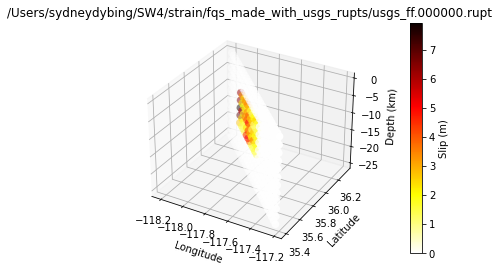

7.1573


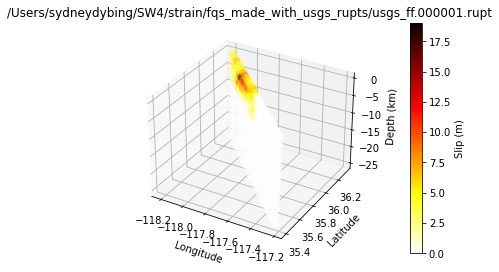

7.2676


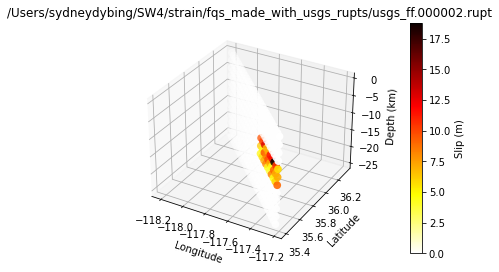

7.2645


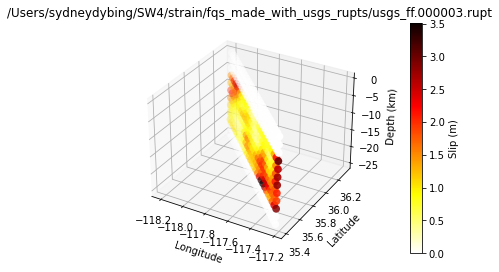

7.0724


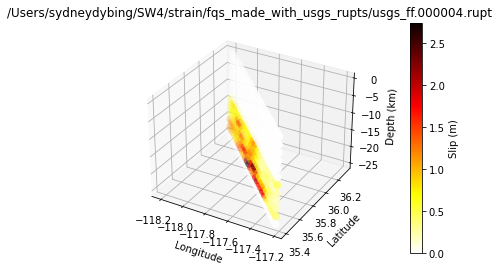

6.9909


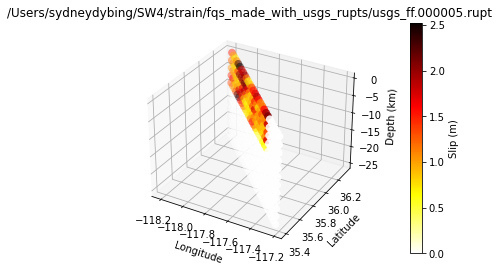

7.1666


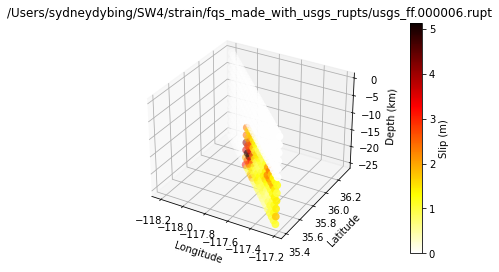

7.1147


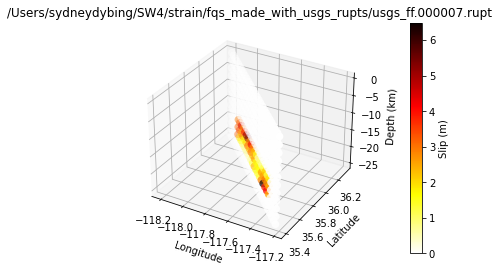

7.2016


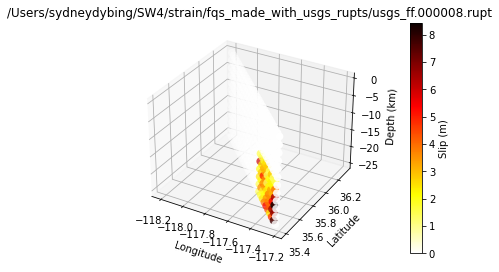

7.0911


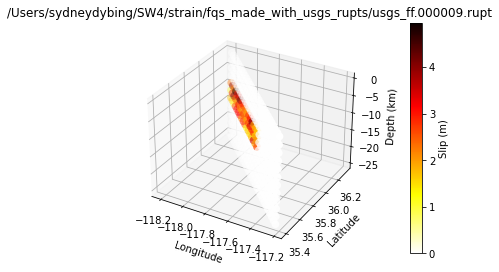

7.0965


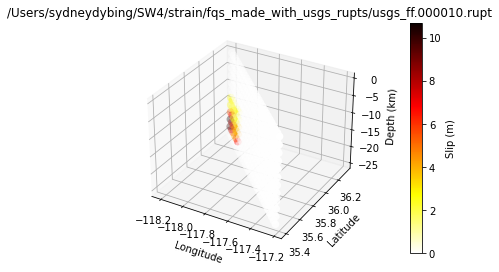

6.9464


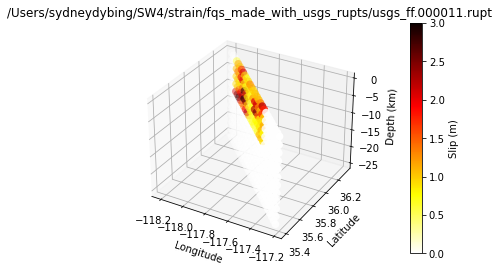

6.9502


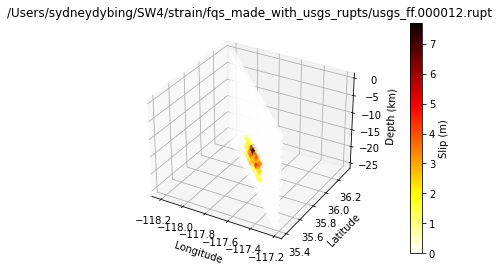

7.1598


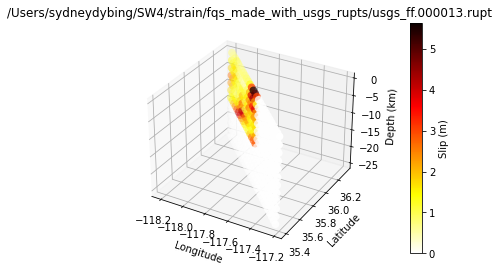

6.7952


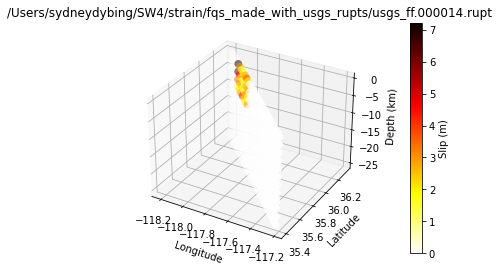

7.2286


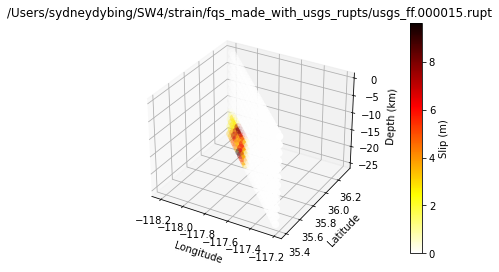

7.1592


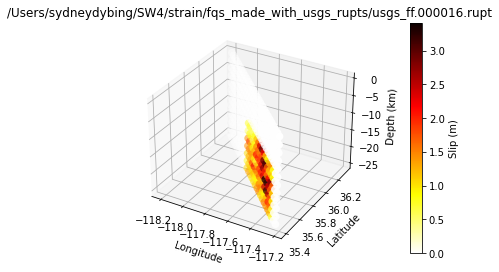

6.8133


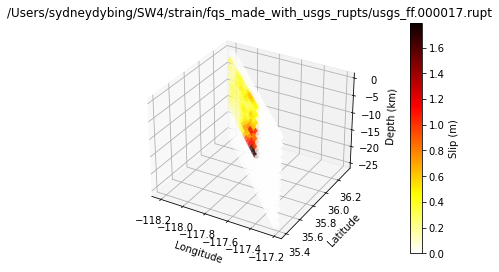

7.3082


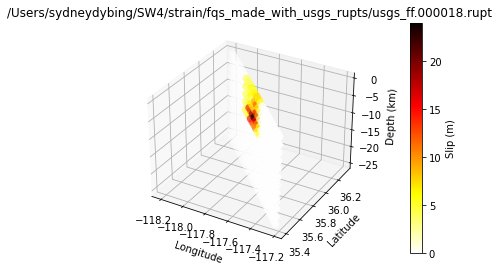

7.044


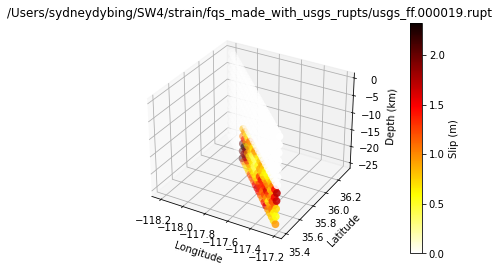

6.8629


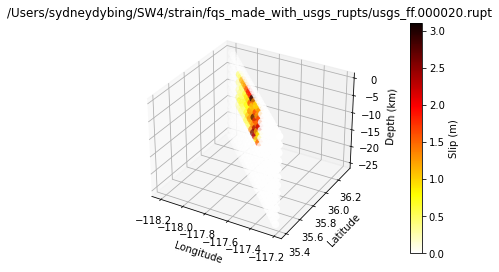

6.8964


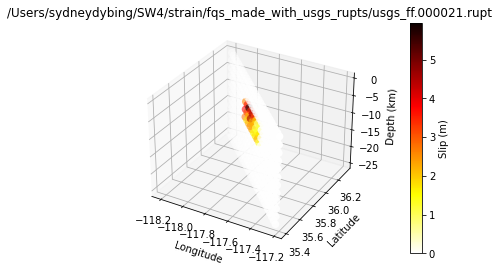

6.9712


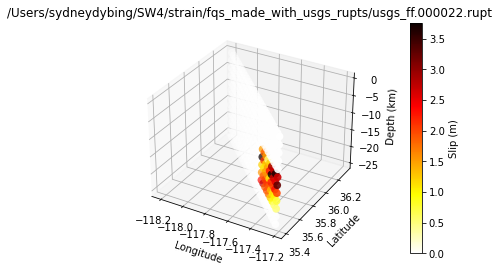

6.9055


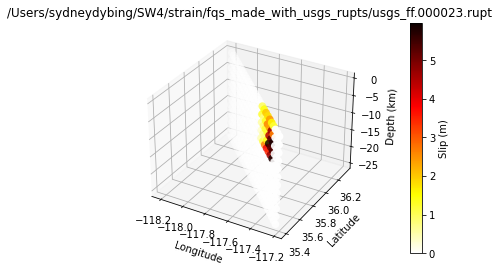

7.0235


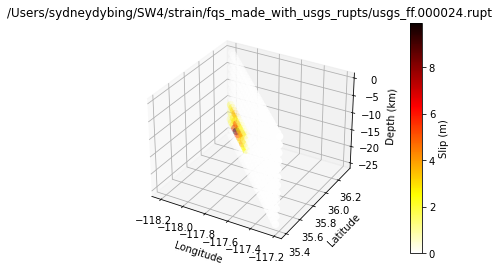

7.0683


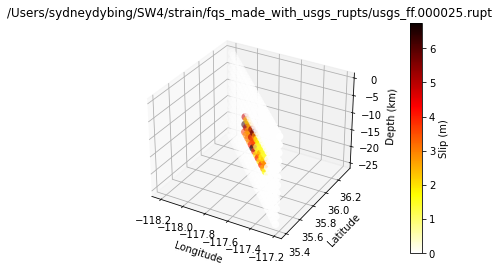

7.2606


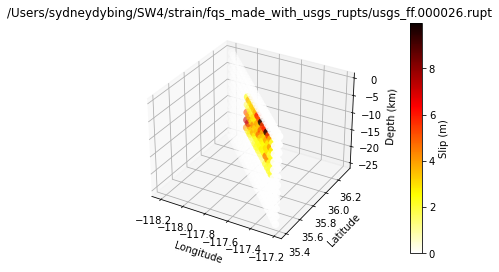

6.8691


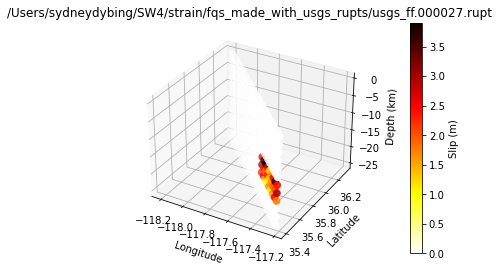

7.1161


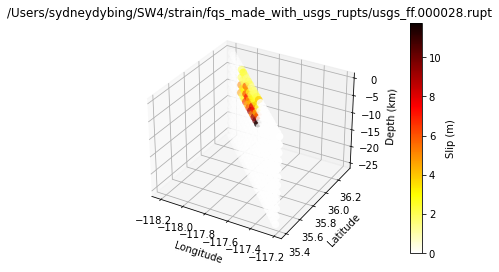

6.8098


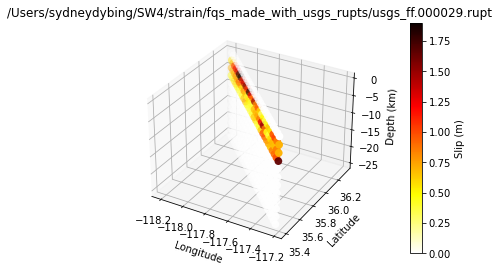

6.9647


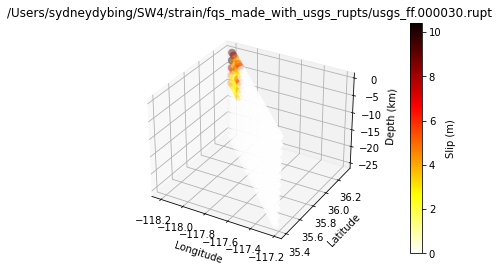

6.7464


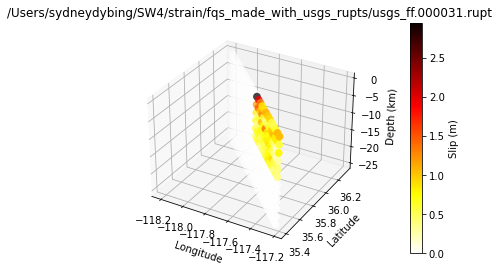

6.942


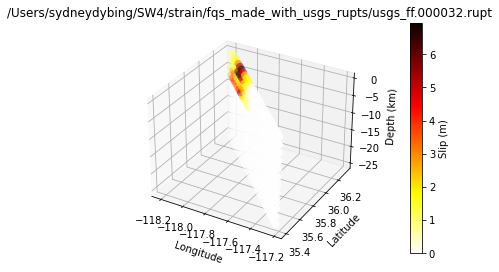

7.0412


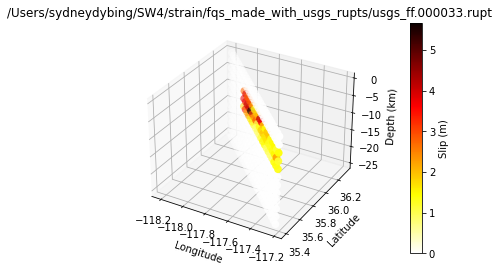

6.527


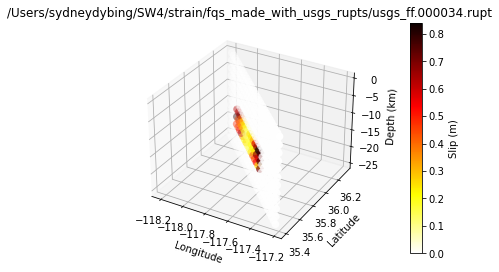

6.8263


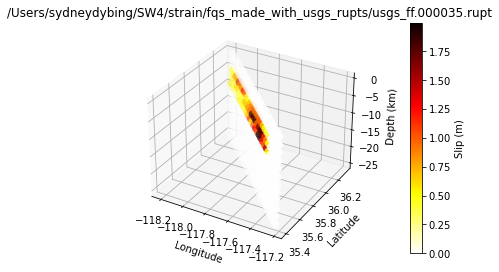

6.6792


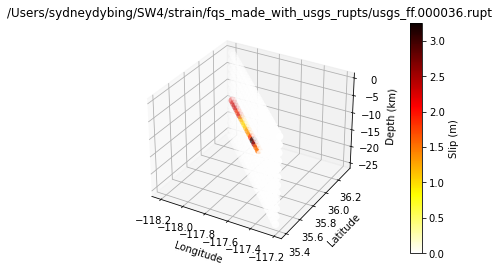

6.9993


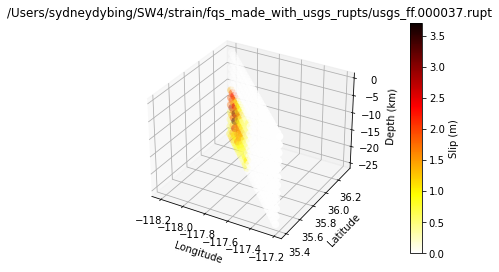

6.9327


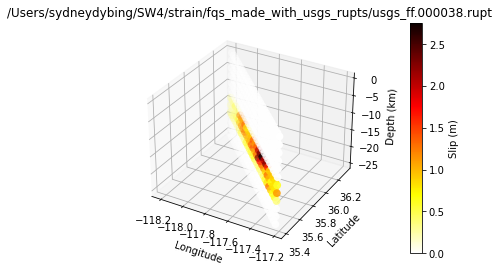

6.9172


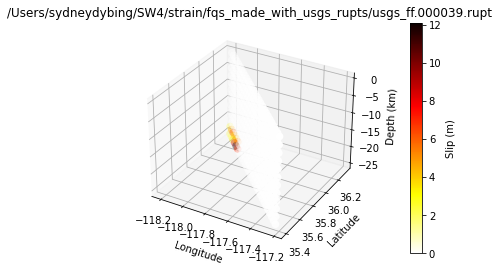

6.5011


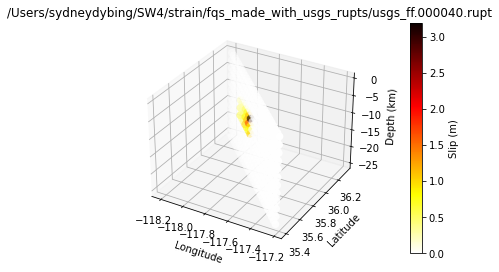

6.9073


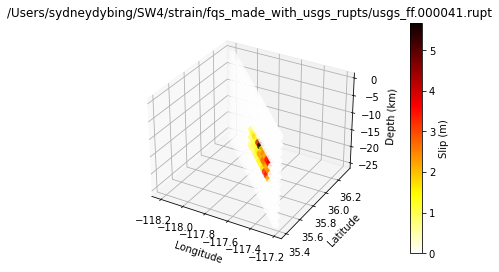

6.4827


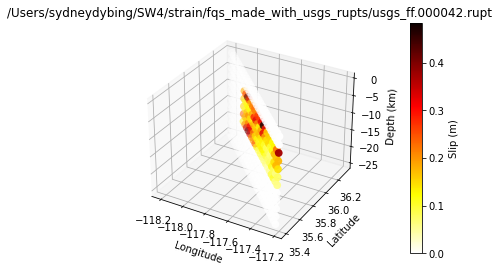

6.8042


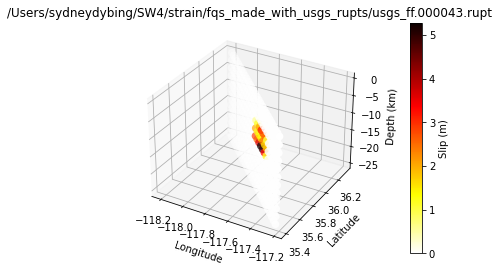

6.601


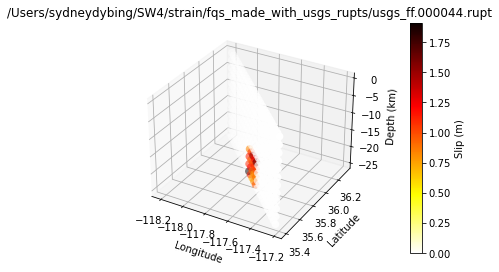

6.8451


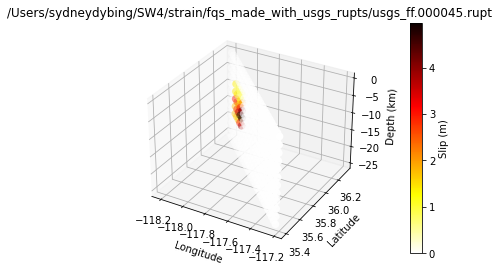

6.5829


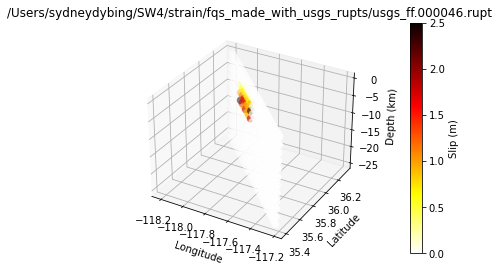

6.8395


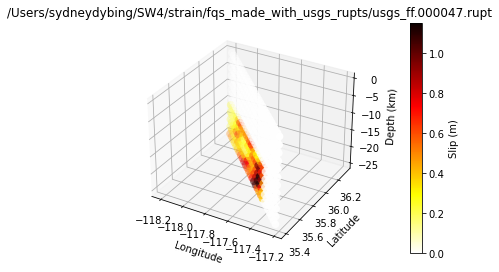

6.6956


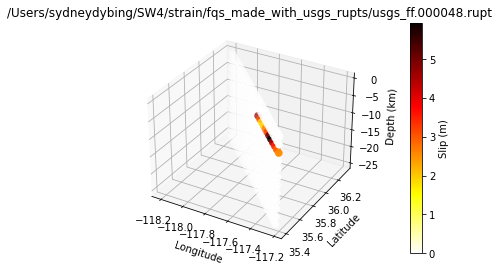

6.3792


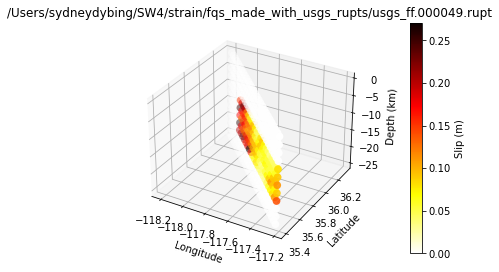

In [31]:
# Look at all the USGS-based FQ ruptures to pick a nice one

ruptures = np.genfromtxt('/Users/sydneydybing/SW4/strain/ruptures.list', dtype = 'str')
# print(ruptures)

for rupture in ruptures:
    
    rupt = '/Users/sydneydybing/SW4/strain/fqs_made_with_usgs_rupts/' + rupture
    log_file = '/Users/sydneydybing/SW4/strain/fqs_made_with_usgs_rupts/' + rupture[:15] + 'log'
    
    flog=open(log_file,'r')
    while True:
        line=flog.readline()
        if 'Actual magnitude' in line:
            Mw=float(line.split()[-1])
        elif line=='':
            break 
    flog.close()
    
#     print(rupt)
#     print(log)

    print(Mw)
    
    slip3D(rupt = rupt)

... working on subfault 0 of 54
... working on subfault 10 of 54
... working on subfault 20 of 54
... working on subfault 30 of 54
... working on subfault 40 of 54
... working on subfault 50 of 54


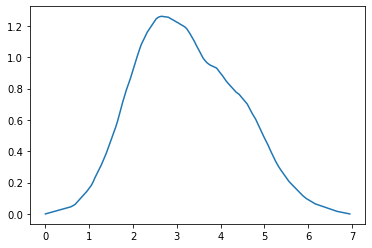

In [28]:
stf = view.source_time_function_FQ(rupt = rupt_fq4, epicenter = 0)
plt.plot(stf[0], stf[1]);

In [11]:
# USGS finite fault for Ridgecrest M7.1
param = '/Users/sydneydybing/SW4/strain/basic_inversion.param'

In [12]:
usgs2rupt(usgs_model = param, out_file = '/Users/sydneydybing/SW4/strain/usgsRC.rupt', Dx = 5000, Dy = 2230)

In [13]:
rupt_usgs = '/Users/sydneydybing/SW4/strain/usgsRC.rupt'
log_usgs = '/Users/sydneydybing/SW4/strain/usgsRC_fakelog.log'

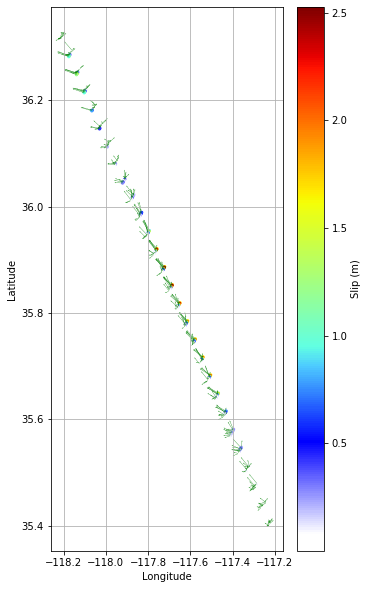

In [14]:
view.quick_model(rupt = rupt_usgs)

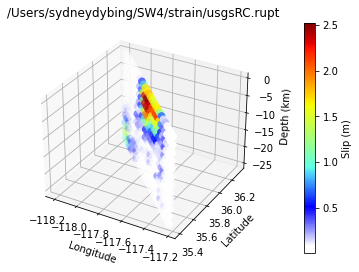

In [15]:
view.slip3D(rupt = rupt_usgs)

In [16]:
def get_mu(structure,zs,return_speeds=False):
    '''
    Look in structure model and compute rigidity given a source depth
    
    IN:
        structure: Array with velocity structure information
        zs: depth in km at which you want to compute mu
        
    OUT:
        mu: Rigidity in Pa
    '''
    from numpy import nonzero
    
    if len(structure)>1: #Model is more than jsut the halfspace
        Z=structure[:,0].cumsum()
        #Which layer do I want?
        i=nonzero(zs>Z)[0]
        if i.size==0: #It's in top layer
            imu=0
        else:
            imu=max(i)+1
        if imu>=structure.shape[0]:
            imu=imu-1#It's int he half-space
        mu=((1000*structure[imu,1])**2)*structure[imu,3]*1000
        beta=1000*structure[imu,1]
        alpha=1000*structure[imu,2]
        #print "Rigidity at z="+str(zs)+' is, mu = '+str(mu/1e9)+'GPa'
    else: #Model is a halfspace
        mu=((1000*structure[0,1])**2)*structure[0,3]*1000 # 1000 * thickness^2 * density*1000
        beta=1000*structure[0,1]
        alpha=1000*structure[0,2]
    
    if return_speeds==False:
        return mu
    else: 
        return mu,alpha,beta
        

In [17]:
rupt_file = np.genfromtxt(rupt_usgs)
zs = rupt_file[:,3] # depths of subfaults

print(zs)
print(len(zs))

structure = np.genfromtxt('/Users/sydneydybing/sw4/strain/mojave.mod', skip_header = 1)
structure[17,0] = 0
# print(structure)

mus = []

for z in zs:
    if z <= 30/1000:
        rho = 2100/1000
    elif 30/1000 < z <= 100/1000:
        rho = 2300/1000
    elif 100/1000 < z <= 300/1000:
        rho = 2400/1000
    elif 300/1000 < z <= 500/1000:
        rho = 2500/1000
    elif 500/1000 < z <= 700/1000:
        rho = 2600/1000
    elif 700/1000 < z <= 1000/1000:
        rho = 2650/1000
    elif 1000/1000 < z <= 3000/1000:
        rho = 2700/1000
    elif 3000/1000 < z <= 5000/1000:
        rho = 2750/1000
    elif 5000/1000 < z <= 6000/1000:
        rho = 2800/1000
    elif 6000/1000 < z <= 11000/1000:
        rho = 2825/1000
    elif 11000/1000 < z <= 16000/1000:
        rho = 2850/1000
    elif 16000/1000 < z <= 21000/1000:
        rho = 2900/1000
    elif 21000/1000 < z <= 31000/1000:
        rho = 2950/1000
    else:
        rho = 3200/1000
    mus.append(np.round(rho,2))

print(mus)
print(len(mus))

[ 0.3734  0.3734  0.3734  0.3734  0.3734  0.3734  0.3734  0.3734  0.3734
  0.3734  0.3734  0.3734  0.3734  0.3734  0.3734  0.3734  0.3734  0.3734
  0.3734  0.3734  0.3734  0.3734  0.3734  0.3734  0.3734  0.3734  0.3734
  0.3734  2.595   2.595   2.595   2.595   2.595   2.595   2.595   2.595
  2.595   2.595   2.595   2.595   2.595   2.595   2.595   2.595   2.595
  2.595   2.595   2.595   2.595   2.595   2.595   2.595   2.595   2.595
  2.595   2.595   4.8165  4.8165  4.8165  4.8165  4.8165  4.8165  4.8165
  4.8165  4.8165  4.8165  4.8165  4.8165  4.8165  4.8165  4.8165  4.8165
  4.8165  4.8165  4.8165  4.8165  4.8165  4.8165  4.8165  4.8165  4.8165
  4.8165  4.8165  4.8165  7.038   7.038   7.038   7.038   7.038   7.038
  7.038   7.038   7.038   7.038   7.038   7.038   7.038   7.038   7.038
  7.038   7.038   7.038   7.038   7.038   7.038   7.038   7.038   7.038
  7.038   7.038   7.038   7.038   9.2595  9.2595  9.2595  9.2595  9.2595
  9.2595  9.2595  9.2595  9.2595  9.2595  9.2595  9.2595 

In [18]:
rupt_file[:,-1] = np.array(mus)
print(rupt_file)

[[ 1.000000e+00 -1.181944e+02  3.632840e+01 ...  2.230000e+03
   3.340000e+01  2.500000e+00]
 [ 2.000000e+00 -1.181580e+02  3.629440e+01 ...  2.230000e+03
   3.120000e+01  2.500000e+00]
 [ 3.000000e+00 -1.181216e+02  3.626050e+01 ...  2.230000e+03
   2.900000e+01  2.500000e+00]
 ...
 [ 3.340000e+02 -1.173028e+02  3.546680e+01 ...  2.230000e+03
   2.100000e+01  2.950000e+00]
 [ 3.350000e+02 -1.172664e+02  3.543280e+01 ...  2.230000e+03
   2.260000e+01  2.950000e+00]
 [ 3.360000e+02 -1.172300e+02  3.539890e+01 ...  2.230000e+03
   2.400000e+01  2.950000e+00]]


In [19]:
def get_source_time_function(mu,area,rise_time,t0,slip):
    '''
    Compute source time function for a given rise time, right now it assumes 1m of slip
    and a triangle STF
    '''
    from numpy import zeros,linspace,where
    
    rise_time=float(rise_time)
    #Initialize outputs
    t=linspace(t0,t0+rise_time,1000)
    Mdot=zeros(t.shape)
    #Triangle gradient
    m=4*mu*area/(rise_time**2)
    #Upwards intercept
    b1=-m*t0
    #Downwards intercept
    b2=m*(t0+rise_time)
    #Assign moment rate
    i=where(t<=t0+rise_time/2)[0]
    Mdot[i]=m*t[i]+b1
    i=where(t>t0+rise_time/2)[0]
    Mdot[i]=-m*t[i]+b2 
    Mdot=Mdot*slip  
    return t,Mdot

In [20]:
def add2stf(t1,Mdot1,t2,Mdot2):
    '''
    Add two overlapping source time functions
    '''
    from numpy import interp,linspace
    #Make interpolation vector
    tstart=min(t1[0],t2[0])
    tend=max(t1[-1],t2[-1])
    ti=linspace(tstart,tend,10000)
    #Interpolate
    Mdot1_interp=interp(ti,t1,Mdot1,left=0,right=0)
    Mdot2_interp=interp(ti,t2,Mdot2,left=0,right=0)
    #Add them up
    Mdot_out=Mdot1_interp+Mdot2_interp
    return ti,Mdot_out

In [21]:
def source_time_function_FQ(rupt,epicenter,plot=False):
    '''
    Get source time function for Fakequake (fix bug in rise_time=0 in subfaults)
    '''
    import matplotlib.pyplot as plt
    from numpy import genfromtxt,unique,log10,where,floor
    
    f=rupt_file
    num=f[:,0]
    #Get slips
    all_ss=f[:,8]
    all_ds=f[:,9]
    #Now parse for multiple rupture speeds
    unum=unique(num)
    nfault=len(unum)
    #Count number of windows
    nwin=len(where(num==unum[0])[0])
    #Get rigidities
    mu=f[0:len(unum),13]
    #Get rise times
    rise_time=f[0:len(unum),7]
    #Get areas
    area=f[0:len(unum),10]*f[0:len(unum),11]
    #Loop over subfaults
    t1=0;M1=0 #reset t1 and M1
    for kfault in range(nfault):
        if kfault%10==0:
            print('... working on subfault '+str(kfault)+' of '+str(nfault))
        #Get rupture times for subfault windows
        i=where(num==unum[kfault])[0]
        trup=f[i,12]
        #Get slips on windows
        ss=all_ss[i]
        ds=all_ds[i]
        #Add it up
        slip=(ss**2+ds**2)**0.5
        if type(M1)==int and rise_time[kfault]!=0: #Get first source time function
            t1,M1=get_source_time_function(mu[kfault],area[kfault],rise_time[kfault],trup[0],slip[0])
#             print(t1)
#             print(M1)
        elif type(M1)!=int and rise_time[kfault]!=0:
            t2,M2=get_source_time_function(mu[kfault],area[kfault],rise_time[kfault],trup[0],slip[0])
            t1,M1=add2stf(t1,M1,t2,M2)
    #Get power
    exp=floor(log10(M1.max()))
    M2=M1.copy()
    M1=M1/(10**exp)
    if plot==True:
        plt.figure()
        plt.fill(t1,M1,'b',alpha=0.5)
        plt.plot(t1,M1,color='k')
        plt.grid()
        plt.xlabel('Time(s)')
        plt.ylabel('Moment Rate ('+r'$\times 10^{'+str(int(exp))+r'}$Nm/s)')
        plt.subplots_adjust(left=0.3, bottom=0.3, right=0.7, top=0.7, wspace=0, hspace=0)
    return t1,M1,M2


... working on subfault 0 of 336
... working on subfault 10 of 336
... working on subfault 20 of 336
... working on subfault 30 of 336
... working on subfault 40 of 336
... working on subfault 50 of 336
... working on subfault 60 of 336
... working on subfault 70 of 336
... working on subfault 80 of 336
... working on subfault 90 of 336
... working on subfault 100 of 336
... working on subfault 110 of 336
... working on subfault 120 of 336
... working on subfault 130 of 336
... working on subfault 140 of 336
... working on subfault 150 of 336
... working on subfault 160 of 336
... working on subfault 170 of 336
... working on subfault 180 of 336
... working on subfault 190 of 336
... working on subfault 200 of 336
... working on subfault 210 of 336
... working on subfault 220 of 336
... working on subfault 230 of 336
... working on subfault 240 of 336
... working on subfault 250 of 336
... working on subfault 260 of 336
... working on subfault 270 of 336
... working on subfault 280 of 

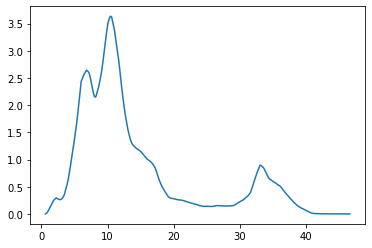

In [22]:
stf = source_time_function_FQ(rupt = rupt_usgs, epicenter = 0)
plt.plot(stf[0], stf[1]);

In [23]:
mudpy2srf(rupt = rupt_usgs, log_file = log_usgs) # writes output file

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27